In [1]:
import hydromt
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join, basename
import glob
import geopandas as gpd
import pygeos
import matplotlib.pyplot as plt

In [2]:
bbox =  32.0, -21.5, 35.5, -17.0
root = r'/mnt/bazis/projects/hydromt-floodmodelling/00_data/'
chunks={'stations': 100, 'time':-1}
rm = {'station_x_coordinate':'lon', 'station_y_coordinate':'lat'}

In [3]:
## read AVISO MDT
mdt_fn = r'/mnt/bazis_data/hydrology/topography/mdt/aviso/MDT_CNES_CLS18_global_filled.tif'
da_mdt = hydromt.open_raster(mdt_fn)
da_mdt

<xarray.DataArray (y: 1440, x: 2880)>
dask.array<getitem, shape=(1440, 2880), dtype=float64, chunksize=(1440, 2880), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 -89.94 -89.81 -89.69 -89.56 ... 89.69 89.81 89.94
  * x            (x) float64 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
    spatial_ref  int64 1
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan

In [4]:
## read CMF pits
mapdir = r'/mnt/bazis/projects/hydromt-floodmodelling/02_models/cmf/map/beira_06min'
gdf_pits = gpd.read_file(join(mapdir, 'gis', 'pits.geojson'))

In [24]:
def cmf_pit_mapping(gdf_gtsm, name, gdf_pits=gdf_pits, mapdir=mapdir, max_dist=10e3):
    pts = pygeos.points([g.coords[:][0] for g in gdf_pits.geometry])
    gtsm_idx = gdf_gtsm.sindex.nearest(pts)[1]
    gdf_pits['gtsm_idx'] = gtsm_idx + 1
    gdf_pits['gtsm_dst']  = gdf_gtsm.iloc[gtsm_idx].to_crs(32736).distance(gdf_pits.to_crs(32736), align=False).values
    gdf_pits = gdf_pits[gdf_pits['gtsm_dst']<max_dist]
    nlinks = gdf_pits.index.size
    print(nlinks)
    cmf_gtsm_ref = gdf_pits[['col', 'row', 'gtsm_idx']].fillna(0).values.astype(np.int32)
    with open(join(mapdir, f'{name}.txt'), 'w') as f:
        f.write(f'{nlinks:d}\n')
        np.savetxt(
            f, 
            cmf_gtsm_ref,
            fmt='%3.d',
        )
    return gdf_pits, cmf_gtsm_ref

In [7]:
## CODEC
name = 'GTSM_CODEC'
fns = glob.glob(join(root, name, 'reanalysis_waterlevel_10min_*_v1_beira.nc'))
ds_gtsm0 = xr.open_dataset(fns[0], chunks=chunks).rename(rm).vector.clip_bbox(bbox)
gdf_gtsm = ds_gtsm0.vector.to_gdf().set_crs(4326)
gdf_gtsm

,geometry
stations,
18278,POINT (34.76100 -20.55200)
17492,POINT (34.87800 -19.84900)
17493,POINT (34.76100 -19.99500)
17494,POINT (34.76100 -20.20000)
12317,POINT (35.02400 -20.72800)
18282,POINT (35.08300 -21.31300)
18280,POINT (35.08300 -20.90300)
18276,POINT (34.79000 -19.87800)
18275,POINT (34.79000 -19.84900)


25


array([[35, 23, 15],
       [33, 24, 15],
       [34, 25, 15],
       [35, 25, 15],
       [32, 27, 13],
       [33, 27, 14],
       [31, 28, 13],
       [27, 29,  8],
       [28, 29,  8],
       [29, 29,  9],
       [27, 31,  4],
       [28, 32,  4],
       [28, 33,  4],
       [27, 34, 10],
       [27, 36,  1],
       [28, 36,  1],
       [30, 37,  5],
       [30, 38,  5],
       [31, 38,  5],
       [31, 40,  7],
       [31, 41, 11],
       [30, 42, 11],
       [31, 43,  6],
       [30, 44,  6],
       [31, 44,  6]], dtype=int32)

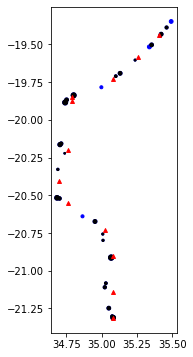

In [25]:
gdf_pits1, cmf_gtsm_ref = cmf_pit_mapping(gdf_gtsm, name)
fig, ax = plt.subplots(1,1, figsize=(6,6))
gdf_pits.plot(markersize=(gdf_pits['upa_10'].values-7)*7, color='b', ax=ax)
gdf_pits1.plot(markersize=(gdf_pits1['upa_10'].values-7)*7, color='k', ax=ax)
gdf_gtsm.iloc[np.unique(gdf_pits1['gtsm_idx'].values-1)].plot(markersize=15, color='r', marker='^', ax=ax)
cmf_gtsm_ref

In [32]:
mdt0 = da_mdt.raster.sample(gdf_gtsm).rename({'index': 'stations'}).reset_coords(drop=True)
for fn in fns: 
    print(basename(fn))
    fn_out = fn.replace('.nc', '_egm.nc')
    ds_gtsm = xr.open_dataset(fn, chunks=chunks).sel(stations=gdf_gtsm.index.values)
    ds_gtsm = ds_gtsm + mdt0
    encoding = {'waterlevel': {'dtype': 'float32'}}
    ds_gtsm.to_netcdf(fn_out, encoding=encoding)

reanalysis_waterlevel_10min_2017_v1_beira.nc
reanalysis_waterlevel_10min_2018_v1_beira.nc
reanalysis_waterlevel_10min_1981_v1_beira.nc
reanalysis_waterlevel_10min_1991_v1_beira.nc
reanalysis_waterlevel_10min_2008_v1_beira.nc
reanalysis_waterlevel_10min_2007_v1_beira.nc
reanalysis_waterlevel_10min_2005_v1_beira.nc
reanalysis_waterlevel_10min_1993_v1_beira.nc
reanalysis_waterlevel_10min_1983_v1_beira.nc
reanalysis_waterlevel_10min_2015_v1_beira.nc
reanalysis_waterlevel_10min_1985_v1_beira.nc
reanalysis_waterlevel_10min_2013_v1_beira.nc
reanalysis_waterlevel_10min_2003_v1_beira.nc
reanalysis_waterlevel_10min_1995_v1_beira.nc
reanalysis_waterlevel_10min_1997_v1_beira.nc
reanalysis_waterlevel_10min_2001_v1_beira.nc
reanalysis_waterlevel_10min_1998_v1_beira.nc
reanalysis_waterlevel_10min_1988_v1_beira.nc
reanalysis_waterlevel_10min_2011_v1_beira.nc
reanalysis_waterlevel_10min_1987_v1_beira.nc
reanalysis_waterlevel_10min_1994_v1_beira.nc
reanalysis_waterlevel_10min_2002_v1_beira.nc
reanalysis

In [28]:
## IDAI / ELOISE
name = 'GTSM_20190218_20190401_IDAI'
tstart, tstop = '2019-01-01', '2019-05-01'
prefix = 'idai'

name = 'GTSM_20201218_20210201_ELOISE'
tstart, tstop = '2021-01-01', '2021-03-01'
prefix = 'eloise'

var = 'waterlevel'
runs = ['era5', 'spw', 'tides', 'era5_tides', 'spw_tides', 'era5_spw_tides']
fn0 = join(root, name, f'{prefix}_{runs[0]}_his.nc')
da_gtsm0 = xr.open_dataset(fn0, chunks=chunks).rename(rm)[var]
da_gtsm0['stations'] = da_gtsm0.stations
da_gtsm0 = da_gtsm0.vector.clip_bbox(bbox)

da_gtsm0.raster.set_crs(4326)
gdf_gtsm = da_gtsm0.vector.to_gdf()
mdt0 = da_mdt.raster.sample(gdf_gtsm).rename({'index': 'stations'}).reset_coords(drop=True)
da_gtsm0.station_name.values

array([b'id_coast_glob_12352', b'id_coast_glob_12353',
       b'id_coast_glob_17536', b'id_coast_glob_17537',
       b'id_coast_glob_17538', b'id_coast_glob_17539',
       b'id_coast_glob_17540', b'id_coast_glob_17541',
       b'id_coast_glob_17542', b'id_coast_glob_18328',
       b'id_coast_glob_18329', b'id_coast_glob_18331',
       b'id_coast_glob_18333', b'id_coast_glob_18335',
       b'id_reg_grid_glob_01456'], dtype='|S64')

25


array([[35, 23,  3],
       [33, 24,  3],
       [34, 25,  3],
       [35, 25,  3],
       [32, 27,  5],
       [33, 27,  4],
       [31, 28,  5],
       [27, 29, 11],
       [28, 29, 11],
       [29, 29, 10],
       [27, 31,  8],
       [28, 32,  8],
       [28, 33,  8],
       [27, 34,  9],
       [27, 36, 12],
       [28, 36, 12],
       [30, 37,  1],
       [30, 38,  1],
       [31, 38,  1],
       [31, 40, 13],
       [31, 41,  2],
       [30, 42,  2],
       [31, 43, 14],
       [30, 44, 14],
       [31, 44, 14]], dtype=int32)

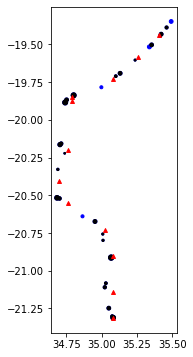

In [29]:
gdf_pits1, cmf_gtsm_ref = cmf_pit_mapping(gdf_gtsm, name)
fig, ax = plt.subplots(1,1, figsize=(6,6))
gdf_pits.plot(markersize=(gdf_pits['upa_10'].values-7)*7, color='b', ax=ax)
gdf_pits1.plot(markersize=(gdf_pits1['upa_10'].values-7)*7, color='k', ax=ax)
gdf_gtsm.iloc[np.unique(gdf_pits1['gtsm_idx'].values-1)].plot(markersize=15, color='r', marker='^', ax=ax)
cmf_gtsm_ref

In [94]:
for run in runs:
    fn = join(root, name, f'{prefix}_{run}_his.nc')
    fn_out = fn.replace('.nc', '_beira.nc')

    # READ
    da_gtsm = xr.open_dataset(fn, chunks=chunks)[var].sel(stations=gdf_gtsm.index)

    # reindex to get timeseries from JAN-01
    time = xr.IndexVariable('time', pd.date_range(tstart, tstop, freq='10MIN'))
    da_gtsm = da_gtsm.resample(time='10MIN').nearest().reindex(time=time, fill_value=0)

    # apply MDT
    if 'tides' in run:
        da_gtsm = da_gtsm + mdt0
        fn_out = fn_out.replace('.nc', '_egm.nc')

    # write to nc
    da_gtsm.name = var
    encoding = {var: {'dtype': 'float32'}}
    da_gtsm.to_netcdf(fn_out, encoding=encoding)

In [96]:
da_gtsm

<xarray.DataArray 'waterlevel' (time: 17281, stations: 15)>
dask.array<add, shape=(17281, 15), dtype=float64, chunksize=(17281, 7), chunktype=numpy.ndarray>
Coordinates:
  * stations              (stations) int64 12317 12318 17489 ... 18282 34418
  * time                  (time) datetime64[ns] 2019-01-01 ... 2019-05-01
    station_x_coordinate  (stations) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    station_y_coordinate  (stations) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    station_name          (stations) |S64 dask.array<chunksize=(2,), meta=np.ndarray>

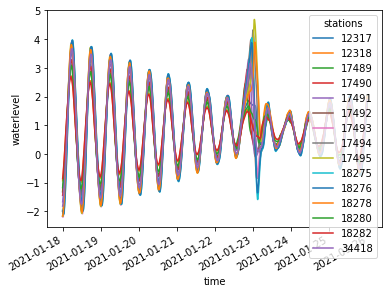

In [91]:
da_gtsm.sel(time=slice('2021-01-18', '2021-01-25')).plot.line(x='time')